# Physiological Predictors: Using Cleveland Metrics to Predict Heart Disease
**Brian Shao, 49953300**

## Introduction

### Background
According to the Government of Canada (2017), heart disease the second leading cause of death in Canada.
Early detection of heart disease is one of the most effective methods of mitigating risk of heart disease; 
therefore, to reduce the effects of heart disease, the ability to detect heart disease is crucial to effective treatment.

This project will attempt to create a predictive model for heart disease using demographic and physiological metrics,
such as age, cholesterol, and heart rate.

### Research Question
How well can a predictive model determine the presence of heart disease using demographic and physiological measurements?

### Dataset
This project will use a modified version of the UCI Heart Disease dataset, which contains information from patients in
Cleveland, Ohio. The dataset contains 14 attributes in patients, such as age, sex, and heart rate, which will be used to
train and test the model.


## Preliminary Exploratory Data Analysis

In [7]:
# 0. Library imports and initialization

library('repr')
library('tidyverse')
library('tidymodels')

options(repr.matrix.max.rows = 6)
options(repr.plot.width = 10)

In [8]:
# 1. Read data and assign column names using names in UCI databse

col_names <- c('age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
data <- read_csv(file = 'data/heart_disease/processed.cleveland.data', na = c('', 'NA', '?'), col_names = col_names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
# 2. Wrangle and tidy data

# wrangle data
heart_data <- data |>
  # relabel categorical variables based on the variables table in UCI database
  mutate(sex = as.factor(case_when(sex == 1 ~ 'male', sex == 0 ~ 'female'))) |>
  mutate(cp = as.factor(case_when(cp == 1 ~ 'typical angina', cp == 2 ~ 'atypical angina', cp == 3 ~ 'non-anginal pain', cp == 4 ~ 'asymptomatic'))) |>
  mutate(fbs = as.factor(case_when(fbs == 1 ~ 'true', fbs == 0 ~ 'false'))) |>
  mutate(restecg = as.factor(case_when(restecg == 0 ~ 'normal', restecg == 1 ~ 'abnormality', restecg == 2 ~ 'hypertrophy'))) |>
  mutate(exang = as.factor(case_when(exang == 1 ~ 'yes', exang == 0 ~ 'no'))) |>
  mutate(slope = as.factor(case_when(slope == 1 ~ 'upsloping', slope == 2 ~ 'flat', slope == 3 ~ 'downsloping'))) |>
  mutate(thal = as.factor(case_when(thal == 3 ~ 'normal', thal == 6 ~ 'fixed defect', thal == 7 ~ 'reversable defect'))) |>
  # replace heart disease values with presence or absence
  mutate(target = as.factor(case_when(num == 0 ~ 'absent', num > 0 ~ 'present'))) |>
  # remove renamed variables
  select(-num)

# set prng random
set.seed(52515)

# split data
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- training(heart_split)

In [10]:
# 3. Summarize training data

summary_table <- heart_train |>
  group_by(target) |>
  summarize(
    count = n(),
    mean_age = mean(age),
    sd_age = sd(age),
    mean_trestbps = mean(trestbps),
    sd_trestbps = sd(trestbps),
    mean_chol = mean(chol),
    sd_chol = sd(chol),
    mean_thalach = mean(thalach),
    sd_thalach = sd(thalach),
  )

summary_table

target,count,mean_age,sd_age,mean_trestbps,sd_trestbps,mean_chol,sd_chol,mean_thalach,sd_thalach
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absent,123,53.21951,9.744722,129.9756,15.97255,244.3496,58.58145,156.8455,19.50579
present,104,57.18269,7.847780,133.1058,18.08283,251.3654,52.02241,137.8942,22.60678


This table shows the number of rows in the dataset that indicate heart disease (present) and not having heart disease (absent),
as well as the mean and standard deviations for the predictor variables: Age, resting blood pressure, cholesterol, and maximum heart rate.

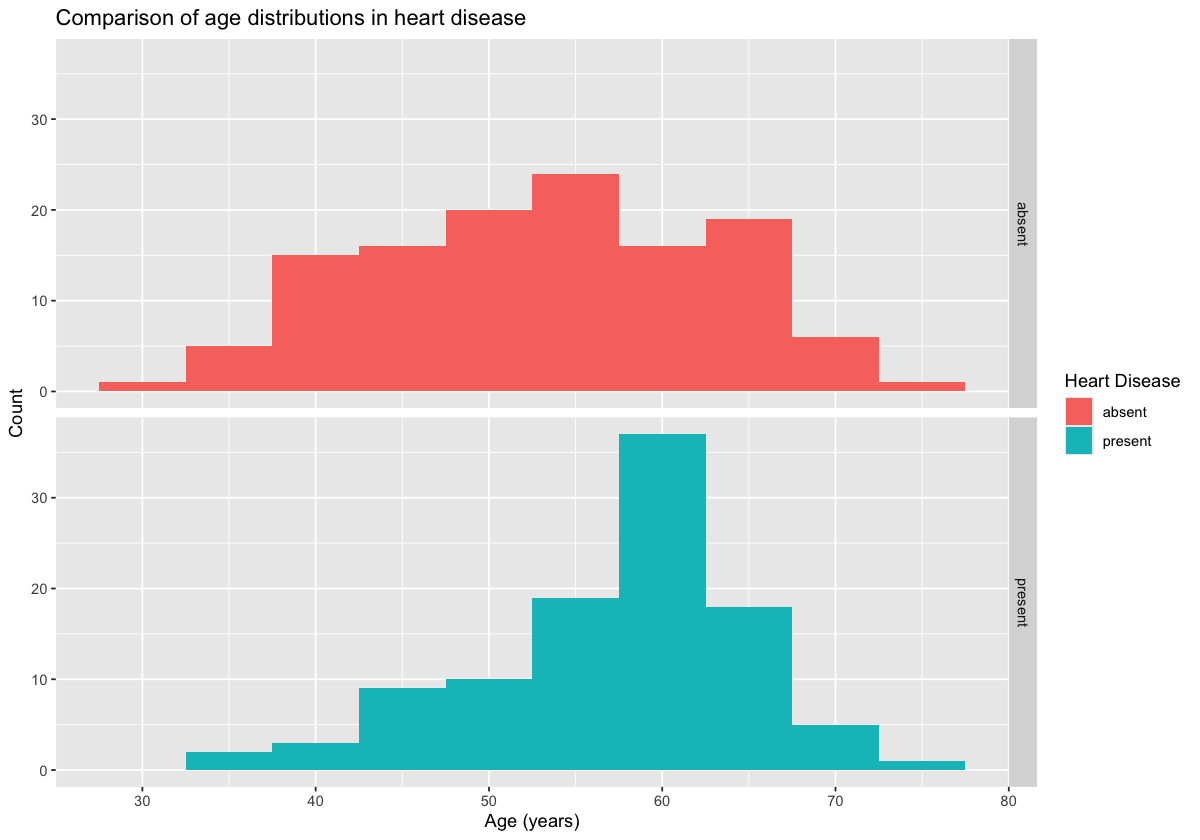

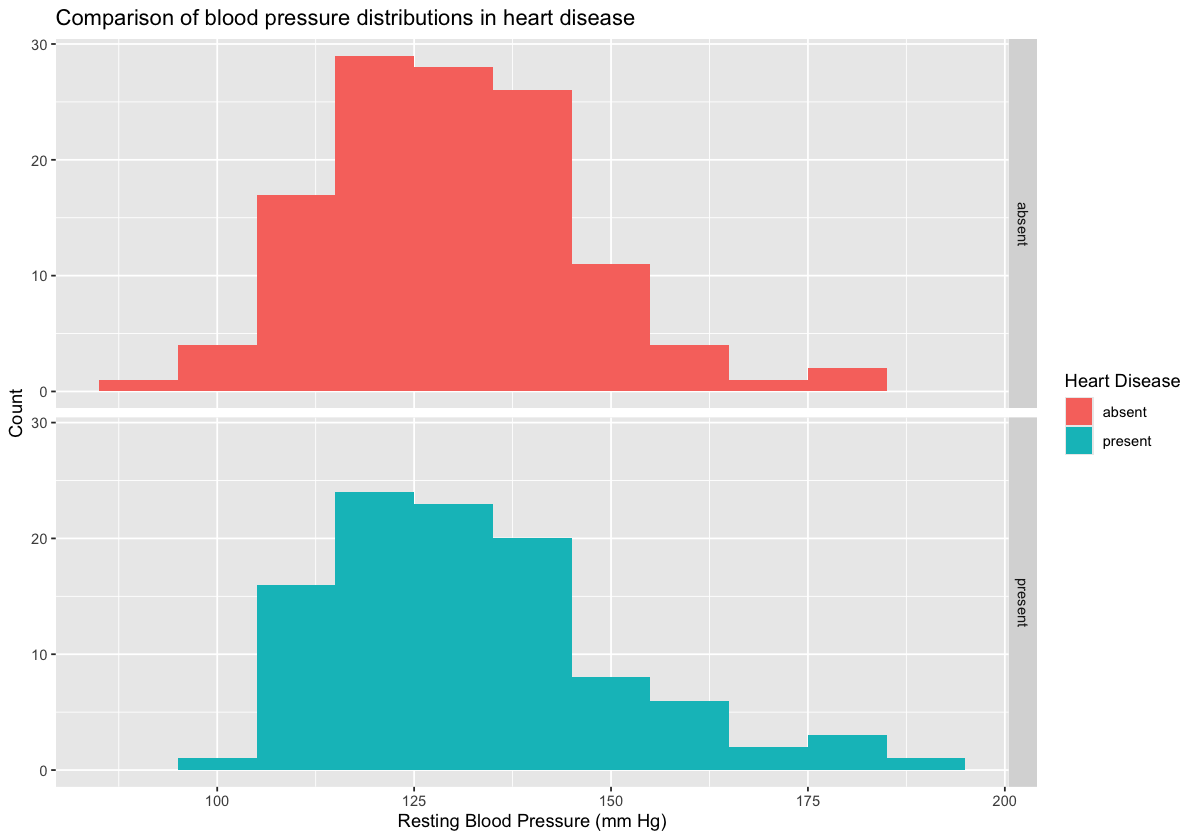

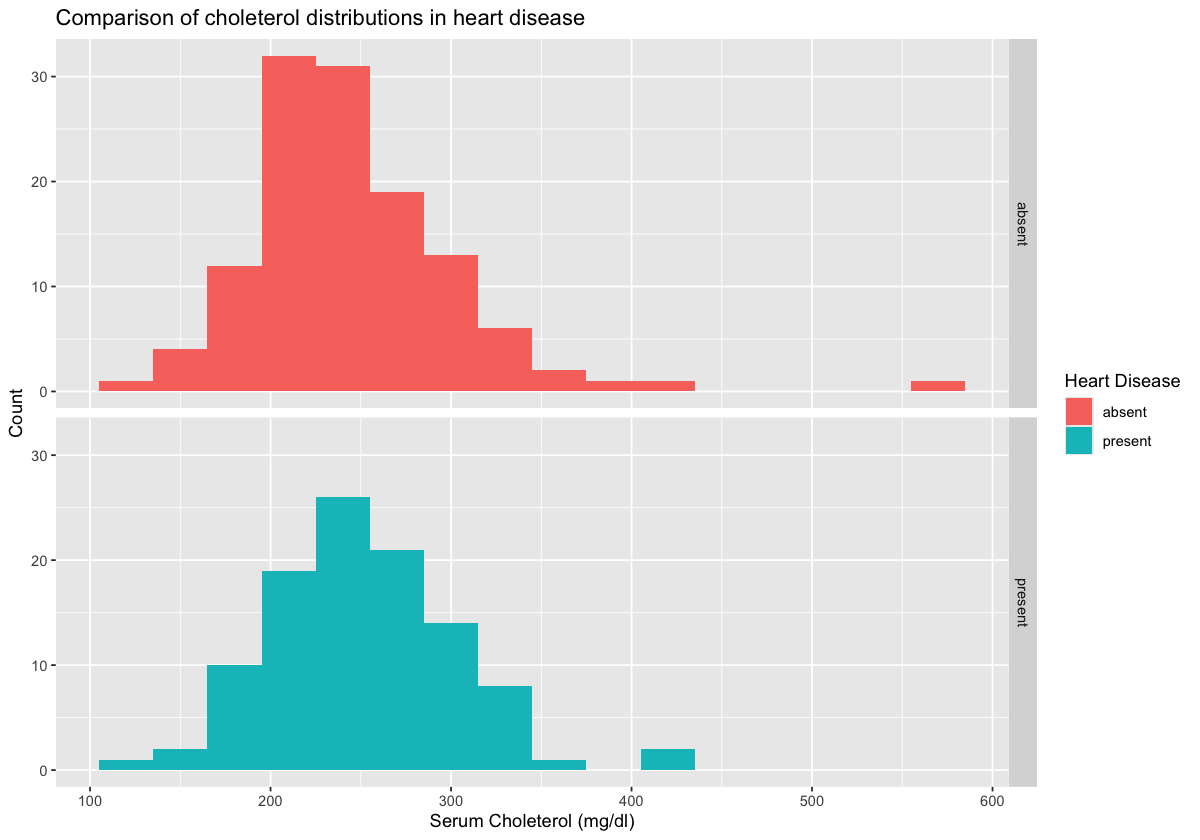

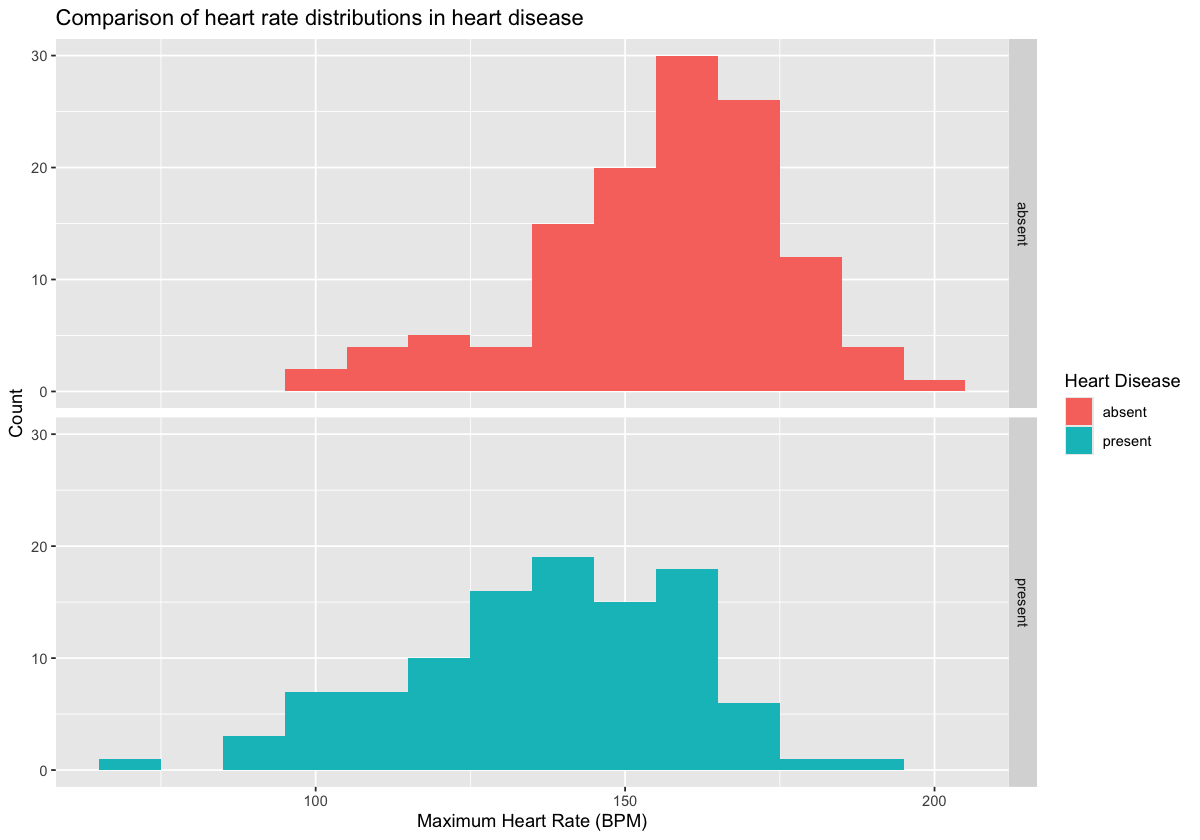

In [11]:
# 4. Visualize training data

heart_train |>
  ggplot(aes(x = age, fill = target)) +
    geom_histogram(binwidth = 5) +
    facet_grid(rows = vars(target)) +
    xlab('Age (years)') +
    ylab('Count') +
    labs(fill = 'Heart Disease') +
    ggtitle('Comparison of age distributions in heart disease')

heart_train |>
  ggplot(aes(x = trestbps, fill = target)) +
  geom_histogram(binwidth = 10) +
  facet_grid(rows = vars(target)) +
  xlab('Resting Blood Pressure (mm Hg)') +
  ylab('Count') +
  labs(fill = 'Heart Disease') +
  ggtitle('Comparison of blood pressure distributions in heart disease')

heart_train |>
  ggplot(aes(x = chol, fill = target)) +
  geom_histogram(binwidth = 30) +
  facet_grid(rows = vars(target)) +
  xlab('Serum Choleterol (mg/dl)') +
  ylab('Count') +
  labs(fill = 'Heart Disease') +
  ggtitle('Comparison of choleterol distributions in heart disease')

heart_train |>
  ggplot(aes(x = thalach, fill = target)) +
  geom_histogram(binwidth = 10) +
  facet_grid(rows = vars(target)) +
  xlab('Maximum Heart Rate (BPM)') +
  ylab('Count') +
  labs(fill = 'Heart Disease') +
  ggtitle('Comparison of heart rate distributions in heart disease')

The four bar plots above show the distributions of the predictor variables (age, resting blood pressure, serum cholesterol, and maximum heart rate)
as histograms, allowing for a side-by-side comparison of each distribution between the present and absent classes (the class to predict).

## Methods

To conduct data analysis, I will train a classification model using the k-nearest neighbours strategy. I will use the age (age),
resting blood pressure (trestbps), serum cholesterol (chol), and maximum heart rate (thalach) variables as predictors for the model,
and the presence of heart disease (target) variable as the outcome. I will use cross-validation with five folds to tune the k-value for the model.

I will visualize results by creating a table of the prediction vs. truth values of the model on
the testing data to determine precision and recall. I will also use a scatterplot to visualize the
accuracy of each k-value during cross-validation.

## Expected Outcomes and Significance

### Hypothesis
I hypothesize that the model will be able to predict the presence of heart disease using the four predictor variables,
but that the model will struggle with identifying heart disease with high accuracy.

### Implications
Early detection of heart disease and identifying those at risk of developing heart disease allow medical professionals
to apply treatment or preventative measures early, greatly reducing the associated risks of heart disease. A model that
can accurately predict the presence of heart disease can help medical professionals make better decisions to help patients.

### Future Inquiry
This model is a basic predictive model that has the potential to be effective; however, different parameters and design
decisions can be explored that may improve accuracy. Future inquiry may explore whether other classification
algorithms yield better results, analyze more (or less) predictive variables, or if additional data (such as from another
dataset or from a different geographical region) leads to consistent results of this model.

## References
Government of Canada. “Heart Disease in Canada.” Canada.ca, 9 Feb. 2017, www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html.